In [1]:
# @title Loading Data Libraries

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab_Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path, header=None)
data = data.to_numpy()



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv
import math
from collections import Counter, defaultdict

Mounted at /content/drive


Data length: 1048576


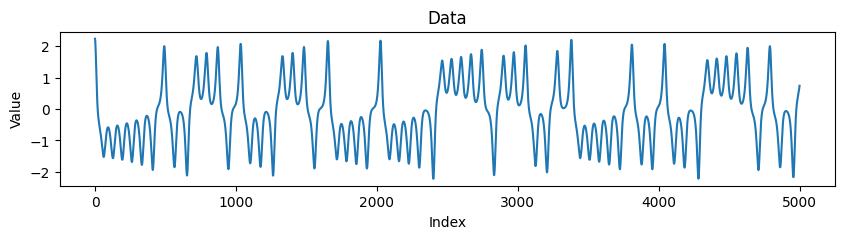

In [2]:
# @title Data Standardization and Visualization

nan_indices = np.argwhere(np.isnan(data))
data_clean = np.delete(data, nan_indices)
mean_value = np.mean(data_clean)
std_dev = np.std(data_clean)
data = (data_clean - mean_value) / std_dev

print('Data length:', data.size)

#Data Visualization
plt.figure(figsize=(10, 2))
plt.plot(data[:5000])
plt.title('Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

Machine learning algorithm:

Let $y:\mathbb{Z}\to\mathbb{R}$ be an original data.
For $K\in\mathbb{Z}_{\geq 1}$,  we choose $\{a_k^K\}_{k=1}^{K}\subset\mathbb{R}$ such that
$a_{1}^K<a_{2}^K<\cdots
<a_{K-1}^K<a_{K}^K$,
\begin{equation*}
\ \text{discretize:}\quad \bar y(t):=\text{argmin}_{a\in\{a_k\}_{k=1}^{K}}|y(t)-a|.
\end{equation*}
  
For $L\in\mathbb{Z}_{\geq 1}$, let $\sigma_n^L$ ($n=1,2,\cdots,N$) be a permutation operator, namely,
\begin{equation*}
\text{``key"}:\quad\sigma_n^L:\{1,2,\cdots, L\}\to\{a_{1},a_{2},\cdots,a_{K-1},a_{K}\}
\end{equation*}

($\ell\mapsto \sigma_n^L(\ell)$) with $\sigma_n^L\not=\sigma_{n'}^L$ ($n\not=n'$), satisfying that
\begin{equation*}
\begin{cases}
\text{For any $t$, there is $n\in\{1,\cdots,N\}$ such that}\\
\quad
\text{$\sigma_n^L(\ell)=\bar y(t-\ell)$ for $\ell=1,2,\cdots, L$},\\
\text{For any  $n\in\{1,\cdots,N\}$ there is $t$ such that}\\
\quad\text{$\sigma_n^L(\ell)=\bar y(t-\ell)$ for $\ell=1,2,\cdots, L$.}
\end{cases}
\end{equation*}

Then we
define
the corresponding ``value" $a_{k(n)}^L$ (this is the learning stage) as follows:
\begin{equation*}
a_{k(n)}^L:=\operatorname*{argmax}_{1\leq k\leq K}P\bigg(a_{k}=\bar y(\cdot)\bigg|\sigma_n^L(\ell)=\bar y(\cdot-\ell)\quad\text{for}\quad \ell=1,2,\cdots,L\bigg),
\end{equation*}
where $P$ is the conditional relative frequency.

In [3]:
# @title Functions required for algebraic machine learning

#Pattern extraction and functions for the following values

def extract_patterns_and_next_values(discretized_data, max_dim,min_count):

    next_values = defaultdict(list)
    pattern_counts = Counter()
    win_vote_rate = {}
    assigned_values = {}
    assigned_value_counts = {}

#Split key-value selection process to save memory
    for c in range(cluster):

        #Erase data here to save memory
        next_values = defaultdict(list)
        assigned_value_counts = {}
        pattern_counts = Counter()


        #Election of key-value pairs
        for dim in range(max_dim-int(max_dim/cluster)*c, max_dim-int(max_dim/cluster)*(c+1), -1):

            num_patterns = len(discretized_data) - dim

            for i in range(num_patterns):

                pattern = tuple(map(tuple, discretized_data[i:i+dim]))
                next_value = tuple(discretized_data[i+dim])
                next_values[pattern].append(next_value)
                pattern_counts[pattern] += 1


        # Direct filtering to remove keys with few occurrences

        patterns_to_remove = [key for key in next_values if pattern_counts[key] < min_count]
        for key in patterns_to_remove:
            del next_values[key]

        each_assigned_values, each_assigned_value_counts = assign_most_frequent_next_value_to_patterns(next_values)

        # Accumulate key-value pairs

        for pattern in each_assigned_values:

            assigned_values[pattern] = each_assigned_values[pattern]
            assigned_value_counts[pattern] = each_assigned_value_counts[pattern]
            win_vote_rate[pattern] = float(assigned_value_counts[pattern]) / float(pattern_counts[pattern])

        del next_values, each_assigned_values, each_assigned_value_counts, patterns_to_remove, pattern_counts

    return win_vote_rate, assigned_values


# Specify the most frequent "next value"

def assign_most_frequent_next_value_to_patterns(next_values):
    assigned_values = {}
    assigned_value_counts = {}


    for pattern, values in next_values.items():
        counts = Counter(values)
        most_common_value = counts.most_common(1)[0][0]
        assigned_values[pattern] = most_common_value
        assigned_value_counts[pattern] = counts[most_common_value]

    return assigned_values, assigned_value_counts

############################
#Discretization of range

def discretize_time_series_1d(data, inverse_cdf_values):
    discretized_data = []
    for value in data:

        # Calculate the distance between each data point and the discrete value and assign the closest discrete value
        nearest_value = min(inverse_cdf_values, key=lambda x: abs(x - value))
        discretized_data.append(nearest_value)
    return discretized_data

def discretize_time_series(data, inverse_cdf_values_list):
    discretized_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        discretized_data[:, i] = discretize_time_series_1d(data[:, i], inverse_cdf_values_list[i])

    return discretized_data
#############################

#Generation of estimated data during the testing phase

def generate_time_series(assigned_values, discretized_initial_data,max_dim,lag,T_test,win_vote_rate):

    time_series = list(map(tuple, discretized_initial_data))
    each_lengths =[]

    for _ in range(int(T_test/lag)+1):

        for shreshold, dim in [(shreshold, dim) for shreshold in [x * 0.05 for x in range(20, 0, -1)] for dim in range(max_dim, 0, -1) ]:

            pattern = tuple(time_series[-dim:])

            if  pattern in win_vote_rate and win_vote_rate[pattern] >= shreshold and pattern in assigned_values:

                 value_to_add = assigned_values[pattern]
                 time_series.append(value_to_add)

                 break

    return time_series

In [4]:
# @title Hyperparameters for Algebraic Machine Learning

T_0     = 1010000      # starting point of the test
T_train = 400000       # T_train steps before T_0 are used as training data

#Make sure that T_0-T_train-max_dim*lag is not negative!


delay_lag = 9   #lag for delay coordinate
delay_dim = 5   #Dimension for delay coordinate

cluster = 8     #Number of divisions for key-value selection process: divisible by max_dim!

max_dim = 40    #Maximum length of key
lag  = 3        #Degree of thinning of time series data
min_count  = 3  #Delete ``keys" that occur less frequently than this. This is also for time saving.
n_bins  = 21    #Number of division of the range

In [5]:
# @title Data Preprocessing

#Multidimensionalization of one-dimensional data by delay coordinates

data_delay = np.zeros((data.shape[0] - delay_dim * delay_lag,delay_dim), dtype=float)

for i in range(delay_dim):

    data_delay[:,i] = data[(delay_dim-i)*delay_lag:data.shape[0]-i*delay_lag] # i列目は i*lag ステップ遅れた時系列


#####################
# Data thinning and discretizing by using cumulative distribution functions
#####################

# Reuse thinned out data
data_segments = [data_delay[T_0 - T_train - max_dim * lag + step:T_0 - max_dim * lag + step:lag]
                 for step in range(lag)]

# Consolidation of thinned data (though rough way)
data_thinned = np.concatenate(data_segments)

#######################
#Preparation for fitting data to inverse CDF discrete values

cdf_values_list = []
bin_edges_list = []

# Compute histogram and CDF for each dimension
for i in range(data_thinned.shape[1]):
    cdf_values, bin_edges = np.histogram(data_thinned[:, i], bins=n_bins, density=True)
    cdf_values = np.cumsum(cdf_values)
    cdf_values_list.append(cdf_values)
    bin_edges_list.append(bin_edges)

# Compute the inverse CDF to obtain n_bins values for each dimension

probability_values = np.linspace(0, 1, n_bins + 1)
inverse_cdf_values_list = []

for i in range(data_thinned.shape[1]):
    inverse_cdf_values = np.interp(probability_values, cdf_values_list[i] / cdf_values_list[i][-1], bin_edges_list[i][:-1])
    inverse_cdf_values_list.append(inverse_cdf_values)

In [6]:
# @title Implementaion of Algebraic Machine Learning

discretized_data= None
assigned_values = None
win_vote_rate = None

# Fit data to discrete values
discretized_data = np.array(discretize_time_series(data_thinned, inverse_cdf_values_list))

#Select the ``value" of each ``key-value"
win_vote_rate,assigned_values  = extract_patterns_and_next_values(discretized_data, max_dim,min_count)

In [11]:
# @title Hyperparameters: test period, number of tests, etc.

test_num = 300        #Number of Tests
t_test = 280          #Testing period after thinning out
T_test = t_test * lag #Pull back to the testing period before thinning out

T_fix = 25            #Visualize learning results for a specific time
T_1= 4000             #Parameters for shifting the test start time

Prediction algorithm:

The following is the crucial idea:
\begin{equation*}
\text{
Winning vote rate:}\quad\frac{\#\Pi^L_n}{\#\Sigma_n^L},
\end{equation*}


\begin{equation*}
\begin{cases}
\text{Key}\quad&\Sigma_n^L:=\{t: \sigma_n^L(\ell)= \bar y(t-\ell)\quad\text{for}\quad \ell=1,2,\cdots, L\},\\
\text{Value of each key}\quad&   \Pi_n^L:=\{t\in \Sigma_n^L: \bar y(t)=a^L_{k(n)}\},
    \end{cases}
\end{equation*}


$\#\Sigma^L_n$: Number of occurrences,

$\#\Pi_n^L$: Number of votes won.



For the front of the prediction time $t$, we look for a matching key $\sigma_n^L$. To do that, we verify

from long $L$-length-key with $1.0$-winning vote rate,

until $1$-length-key with $0.0$-winning vote rate.

Once we found a matching key $\sigma^L_n$, we decide the corresponding value $a^L_{k(n)}$ as the prediction:
\begin{equation*}
    \hat y(t):=a^L_{k(n)}.
\end{equation*}
Then, for the new front of the prediction time $t+1$, we do the same thing again, inductively.



Correlation with ORIGINAL data (PCC): 0.5809349448344535
forecast period: 840


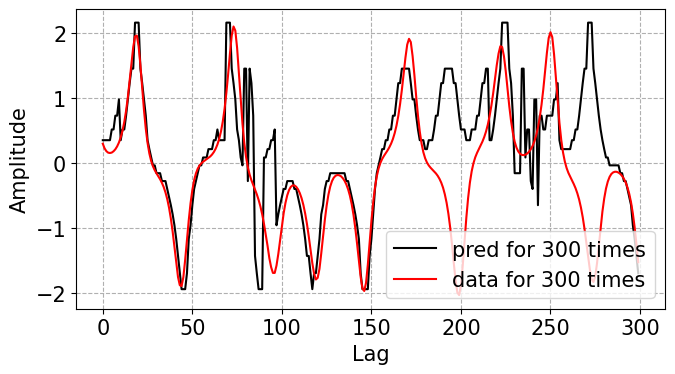

Correlation with ORIGINAL data (PCC): 0.5809349448344535
forecast period: 840
starting point: 117


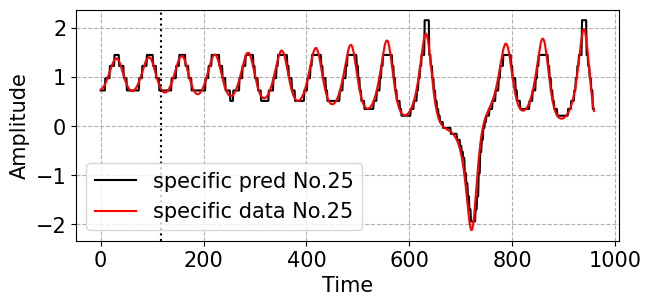

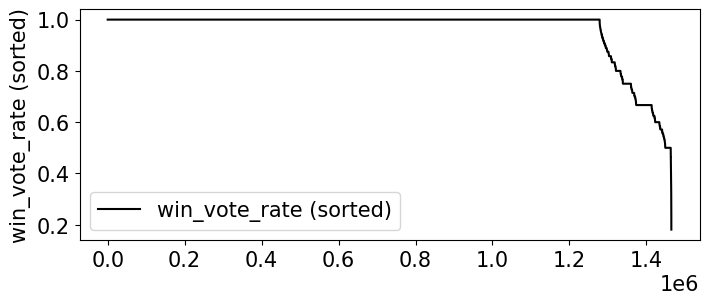

In [16]:
# @title Prediction and Model Evaluation


test_Y = np.zeros((max_dim*lag+T_test,test_num,delay_dim))
test_D = np.zeros((max_dim*lag+T_test,test_num,delay_dim))

#Create test data as a delay coordinate system

for t in range(test_num):

    test_D[:,t,:] = data_delay[T_0-max_dim*lag+T_1+lag*t:T_0+T_test+T_1+lag*t,:]


#Prediction

for t in range(test_num):

    discretized_initial_data = discretize_time_series(data_delay[T_0-max_dim*lag+T_1+lag*t:T_0+T_1+lag*t:lag], inverse_cdf_values_list)
    prediction = generate_time_series(assigned_values, discretized_initial_data,max_dim,lag,T_test-1,win_vote_rate)

# Restore thinned-out forecast data
    expanded_prediction = []

    for value in prediction:
        expanded_prediction.extend([value] * lag)

    expanded_prediction = np.array(expanded_prediction)
    test_Y[:expanded_prediction.shape[0],t,:] = expanded_prediction

######################
#Definition of autocorrelation

def correlation(data1_in, data2_in):

    mean1 = np.mean(data1_in[:])
    mean2 = np.mean(data2_in[:])
    numerator = np.sum((data1_in[:] - mean1) * (data2_in[:] - mean2))
    denominator = np.sqrt(np.sum((data1_in[:] - mean1) ** 2)) * np.sqrt(np.sum((data2_in[:] - mean2) ** 2))

    return numerator / denominator

#Preparation for calculating autocorrelation

test_Y_cor = np.zeros((test_num, delay_dim))
data_delay_cor = np.zeros((test_num, delay_dim))

for t in range(test_num):

    test_Y_cor[t,:] = test_Y[max_dim*lag+T_test-1,t,:]
    data_delay_cor[t,:] = test_D[max_dim*lag+T_test-1,t,:]


# Calculate autocorrelation coefficient

ac_flt = correlation(test_Y_cor[:],data_delay_cor[:])

#####################
#可視化
#####################

print("Correlation with ORIGINAL data (PCC):", ac_flt)
print("forecast period:", T_test)

fig = plt.figure(figsize=(7,4), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.plot(test_Y_cor[:,0], color="black", label=f"pred for {test_num} times")
plt.plot(data_delay_cor[:,0], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

print("Correlation with ORIGINAL data (PCC):",ac_flt)
print("forecast period:", T_test)

# テスト予測の実行
plt.figure(figsize=(7, 3))
plt.plot(test_Y[:,T_fix,0], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix,0], color = "red",label=f"specific data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')
plt.axvline(x=(max_dim-1)*lag, ymin=0, ymax=1, color='k', linestyle=':')
print("starting point:",(max_dim-1) * lag)
plt.show()

###################################################
# Visualization of winning vote rate, sorted by size

sorted_values = sorted(win_vote_rate.values(), reverse=True)
fig, ax1=plt.subplots(figsize=(8,3))

ax1.plot(sorted_values, color='black', label='win_vote_rate (sorted)')
ax1.set_ylabel('win_vote_rate (sorted)')
ax1.legend()